<a id="introduction"></a>
## Introduction to Dask
#### By Paul Hendricks
-------

In this notebook, we will show how to get started with Dask using basic Python primitives like integers and strings.

**Table of Contents**

* [Introduction to Dask](#introduction)
* [Setup](#setup)
* [Introduction to Dask](#dask)
* [Conclusion](#conclusion)

<a id="setup"></a>
## Setup

This notebook was tested using the following Docker containers:

* `rapidsai/rapidsai-dev-nightly:0.10-cuda10.0-devel-ubuntu18.04-py3.7` container from [DockerHub](https://hub.docker.com/r/rapidsai/rapidsai-nightly)

This notebook was run on the NVIDIA GV100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks-contrib/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [ ]:
!nvidia-smi

Next, let's see what CUDA version we have:

In [ ]:
!nvcc --version

## Install graphviz
The visualizations in this notebook require graphviz.  Your environment may not have it installed, but don't worry! If you don't, we're going to install it now.  This can take a little while, so sit tight.

In [7]:
import os
try:
    import graphviz
except ModuleNotFoundError:
    os.system('conda install -c conda-forge graphviz -y')
    os.system('conda install -c conda-forge python-graphviz -y')

<a id="dask"></a>
## Introduction to Dask

Dask is a library the allows for parallelized computing. Written in Python, it allows one to compose complex workflows using large data structures like those found in NumPy, Pandas, and cuDF. In the following examples and notebooks, we'll show how to use Dask with cuDF to accelerate common ETL tasks as well as build and train machine learning models like Linear Regression and XGBoost.

To learn more about Dask, check out the documentation here: http://docs.dask.org/en/latest/

#### Client/Workers

Dask operates by creating a cluster composed of a "client" and multiple "workers". The client is responsible for scheduling work; the workers are responsible for actually executing that work. 

Typically, we set the number of workers to be equal to the number of computing resources we have available to us. For CPU based workflows, this might be the number of cores or threads on that particlular machine. For example, we might set `n_workers = 8` if we have 8 CPU cores or threads on our machine that can each operate in parallel. This allows us to take advantage of all of our computing resources and enjoy the most benefits from parallelization.

On a system with one or more GPUs, we usually set the number of workers equal to the number of GPUs available to us. Dask is a first class citizen in the world of General Purpose GPU computing and the RAPIDS ecosystem makes it very easy to use Dask with cuDF and XGBoost. 

Before we get started with Dask, we need to setup a Local Cluster of workers to execute our work and a Client to coordinate and schedule work for that cluster. As we see below, we can inititate a `cluster` and `client` using only few lines of code.

In [1]:
import dask; print('Dask Version:', dask.__version__)
from dask.distributed import Client, LocalCluster


# create a local cluster with 4 workers
n_workers = 4
cluster = LocalCluster(n_workers=n_workers)
client = Client(cluster)

Dask Version: 2.30.0


Let's inspect the `client` object to view our current Dask status. We should see the IP Address for our Scheduler as well as the the number of workers in our Cluster. 

In [ ]:
# show current Dask status
client

You can also see the status and more information at the Dashboard, found at `http://<ip_address>/status`. You can ignore this for now, we'll dive into this in subsequent tutorials.

With our client and workers setup, it's time to execute our first program in parallel. We'll define a function called `add_5_to_x` that takes some value `x` and adds 5 to it.

In [3]:
def add_5_to_x(x):
    return x + 5

Next, we'll iterate through our `n_workers` and create an execution graph, where each worker is responsible for taking its ID and passing it to the function `add_5_to_x`. For example, the worker with ID 2 will take its ID and pass it to the function `add_5_to_x`, resulting in the value 7.

In [4]:
from dask import delayed

# delayed(<function>)(<input for function>)
addition_operations = [delayed(add_5_to_x)(i) for i in range(n_workers)]
addition_operations

[Delayed('add_5_to_x-85bf18b7-856d-41d6-964f-d2fe27ca5364'),
 Delayed('add_5_to_x-de03337b-249b-4ccb-b809-c0e87b7b9e3d'),
 Delayed('add_5_to_x-793039cb-7c7c-40cb-8c4a-a0cb45449286'),
 Delayed('add_5_to_x-b34e95c5-7bf0-4c20-811f-06d537a25825')]

The above output shows a list of several `Delayed` objects. An important thing to note is that the workers aren't actually executing these results - we're just defining the execution graph for our client to execute later. The `delayed` function wraps our function `add_5_to_x` and returns a `Delayed` object. This ensures that this computation is in fact "delayed" - or lazily evaluated - and not executed on the spot i.e. when we define it.

Next, let's sum each one of these intermediate results. We can accomplish this by wrapping Python's built-in `sum` function using our `delayed` function and storing this in a variable called `total`.

In [5]:
total = delayed(sum)(addition_operations)
total

Delayed('sum-440b5538-cf9e-477d-98e4-39eeb2fa0cf3')

Using the `graphviz` library, we can use the `visualize` method of a `Delayed` object to visualize our current graph.

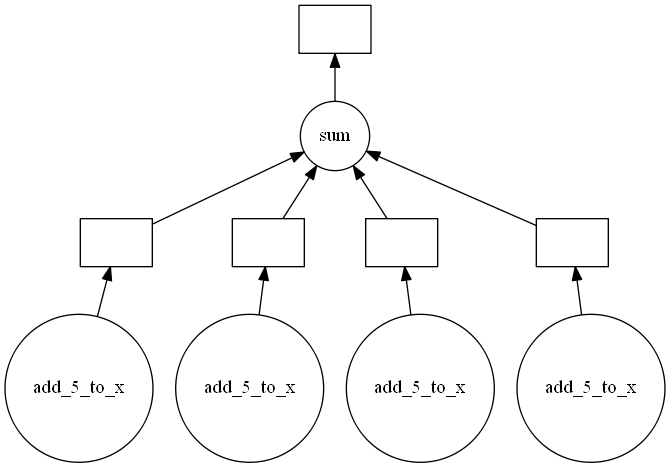

In [8]:
total.visualize()

As we mentioned before, none of these results - intermediate or final - have actually been compute. We can compute them using the `compute` method of our `client`.

In [9]:
from dask.distributed import wait
import time

# addition_operations is a list
addition_futures = client.compute(addition_operations, optimize_graph=False, fifo_timeout="0ms") # add_5_to_x
total_future = client.compute(total, optimize_graph=False, fifo_timeout="0ms") # sum
wait(total_future)  # this will give Dask time to execute the work

DoneAndNotDoneFutures(done={<Future: finished, type: builtins.int, key: sum-440b5538-cf9e-477d-98e4-39eeb2fa0cf3>}, not_done=set())

Let's inspect the output of each call to `client.compute`:

In [10]:
addition_futures

[<Future: finished, type: builtins.int, key: add_5_to_x-85bf18b7-856d-41d6-964f-d2fe27ca5364>,
 <Future: finished, type: builtins.int, key: add_5_to_x-de03337b-249b-4ccb-b809-c0e87b7b9e3d>,
 <Future: finished, type: builtins.int, key: add_5_to_x-793039cb-7c7c-40cb-8c4a-a0cb45449286>,
 <Future: finished, type: builtins.int, key: add_5_to_x-b34e95c5-7bf0-4c20-811f-06d537a25825>]

We can see from the above output that our `addition_futures` variable is a list of `Future` objects - not the "actual results" of adding 5 to each of `[0, 1, 2, 3]`. These `Future` objects are a promise that at one point a computation will take place and we will be left with a result. Dask is responsible for fulfilling that promise by delegating that task to the appropriate Dask worker and collecting the result.

Let's take a look at our `total_future` object:

In [11]:
print(total_future)
print(type(total_future))

<Future: finished, type: builtins.int, key: sum-440b5538-cf9e-477d-98e4-39eeb2fa0cf3>
<class 'distributed.client.Future'>


Again, we see that this is an object of type `Future` as well as metadata about the status of the request (i.e. whether it has finished or not), the type of the result, and a key associated with that operation. To collect and print the result of each of these `Future` objects, we can call the `result()` method.

In [12]:
addition_results = [future.result() for future in addition_futures]
print('Addition Results:', addition_results)

Addition Results: [5, 6, 7, 8]


Now we see the results that we want from our addition operations. We can also use the simpler syntax of the `client.gather` method to collect our results.

In [13]:
addition_results = client.gather(addition_futures) # add_5_to_x
total_result = client.gather(total_future) # sum

print('Addition Results:', addition_results)
print('Total Result:', total_result)

Addition Results: [5, 6, 7, 8]
Total Result: 26


Awesome! We just wrote our first distributed workflow.

To confirm that Dask is truly executing in parallel, let's define a function that sleeps for 1 second and returns the string "Success!". In serial, this function should take our 4 workers around 4 seconds to execute.

In [14]:
def sleep_1():
    time.sleep(1)
    return 'Success!'

In [15]:
%%time

for _ in range(n_workers):
    sleep_1()

Wall time: 4.02 s


As expected, our process takes about 4 seconds to run. Now let's execute this same workflow in parallel using Dask.

In [16]:
%%time

# define delayed execution graph
sleep_operations = [delayed(sleep_1)() for _ in range(n_workers)]

# use client to perform computations using execution graph
sleep_futures = client.compute(sleep_operations, optimize_graph=False, fifo_timeout="0ms")

# collect and print results
sleep_results = client.gather(sleep_futures)
print(sleep_results)

['Success!', 'Success!', 'Success!', 'Success!']
Wall time: 1.04 s


Using Dask, we see that this whole process takes a little over a second - each worker is executing in parallel!

<a id="conclusion"></a>
## Conclusion

In this tutorial, we learned how to use Dask with basic Python primitives like integers and strings.

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)